In [2]:
from datasets import load_dataset

ds = load_dataset("TheFinAI/fiqa-sentiment-classification")


c:\Nayan\Projects\fin-sentiment\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds["train"].to_csv("train.csv")
ds["valid"].to_csv("valid.csv")
ds["test"].to_csv("test.csv")

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 299.57ba/s]


30193

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['_id', 'sentence', 'target', 'aspect', 'score', 'type'],
        num_rows: 822
    })
    test: Dataset({
        features: ['_id', 'sentence', 'target', 'aspect', 'score', 'type'],
        num_rows: 234
    })
    valid: Dataset({
        features: ['_id', 'sentence', 'target', 'aspect', 'score', 'type'],
        num_rows: 117
    })
})

In [5]:
raw_ds = ds["train"]
raw_ds[0]

{'_id': '1',
 'sentence': 'Royal Mail chairman Donald Brydon set to step down',
 'target': 'Royal Mail',
 'aspect': 'Corporate/Appointment',
 'score': -0.374,
 'type': 'headline'}

In [6]:
raw_ds.features

{'_id': Value('string'),
 'sentence': Value('string'),
 'target': Value('string'),
 'aspect': Value('string'),
 'score': Value('float64'),
 'type': Value('string')}

In [7]:
import pandas as pd
df = pd.DataFrame(ds['train']) 
#seeing into a few peices of data
print("Data Head:")
print(df.head())


print("\nData Info:")
df.info()



Data Head:
    _id                                           sentence  \
0     1  Royal Mail chairman Donald Brydon set to step ...   
1   100     Slump in Weir leads FTSE down from record high   
2  1000  AstraZeneca wins FDA approval for key new lung...   
3  1002  UPDATE 1-Lloyds to cut 945 jobs as part of 3-y...   
4  1005  Standard Chartered Shifts Emerging-Markets Str...   

               target                        aspect  score      type  
0          Royal Mail         Corporate/Appointment -0.374  headline  
1                Weir  Market/Volatility/Volatility -0.827  headline  
2         AstraZeneca          Corporate/Regulatory  0.549  headline  
3              Lloyds            Corporate/Strategy -0.266  headline  
4  Standard Chartered            Corporate/Strategy -0.461  headline  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  ----

In [8]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
_id         0
sentence    0
target      0
aspect      0
score       0
type        0
dtype: int64


In [9]:
#checking for score min and max
df["score"].min().item(), df["score"].max().item()

(-0.938, 0.937)

**Binning Strategy**

-ve = [-1, 0.33]
nuetral = [-0.33,0.33]
+ve = [0.33,1]

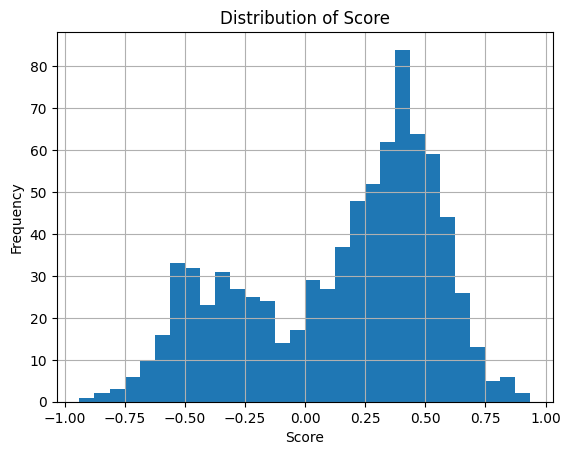

In [10]:
from matplotlib import pyplot as plt
df["score"].hist(bins=30)
plt.title("Distribution of Score")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

**DATA DISTRIBUTION**

It shows a **bimodal distribution**, which is a distribution with two distinct peaks.

1. Positive Peak: There is a large, clear peak on the positive side, likely centered around a score of +0.4 to +0.5.

2. Negative Peak: There is a second, smaller peak on the negative side, likely centered around -0.5.

3. The "Neutral" Valley: The area between your proposed neutral thresholds (-0.33 to 0.33) is not a peak; it's a trough or valley. This means there are far fewer sentences that annotators considered truly neutral.

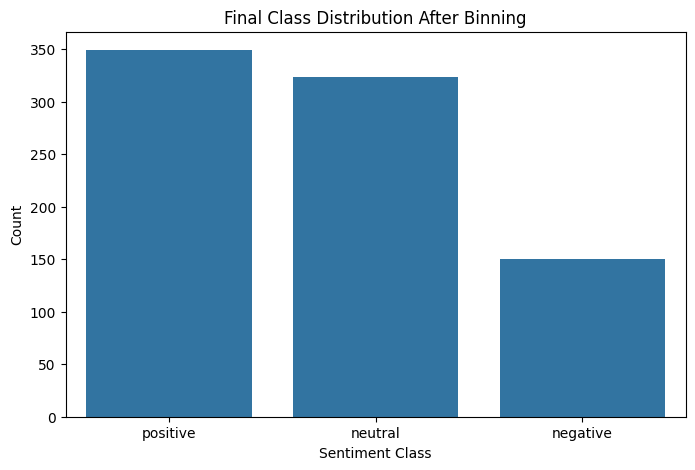

sentiment_class
positive    349
neutral     323
negative    150
Name: count, dtype: int64


In [20]:
import seaborn as sns

bins = [-1, -0.33, 0.33, 1] 
labels = ['negative', 'neutral', 'positive']
df['sentiment_class'] = pd.cut(df['score'], bins=bins, labels=labels, right=False)

# Visualize the final class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_class', data=df, order=['positive', 'neutral', 'negative'])
plt.title('Final Class Distribution After Binning')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.show()

# Print the exact counts
print(df['sentiment_class'].value_counts())

**Strategy** 

Don't bin the scores at all! Instead of classifying, train your transformer model to predict the continuous score value directly.

The beauty of the regression approach is that we decouple the model's core task (understanding sentiment intensity) from the business rule (defining the classification thresholds).



**Why This is a Superior Approach**

**Preserves Information**: The model learns the full spectrum of sentiment intensity. A sentence predicted at 0.8 is clearly more positive than one at 0.4. A classification model forces both into the same "positive" bucket, losing this valuable nuance.

**Flexibility and Tunability**: This is the biggest advantage. Imagine the stakeholders test the model and say, "Your neutral category is too broad; we're getting too many weakly positive sentences labeled as neutral."
With a Classification Model: We would have to re-label your entire dataset with new rules and retrain the entire model from scratch, which is expensive and time-consuming.
With your Regression Model: You simply change one line of code in your inference function.

**Better Handling of Ambiguity**: The regression model isn't forced to make a hard choice on ambiguous sentences during training. It can simply learn to predict a score near zero (e.g., 0.05). This often leads to a more robust model because it's not being penalized for being uncertain about sentences that are inherently ambiguous.

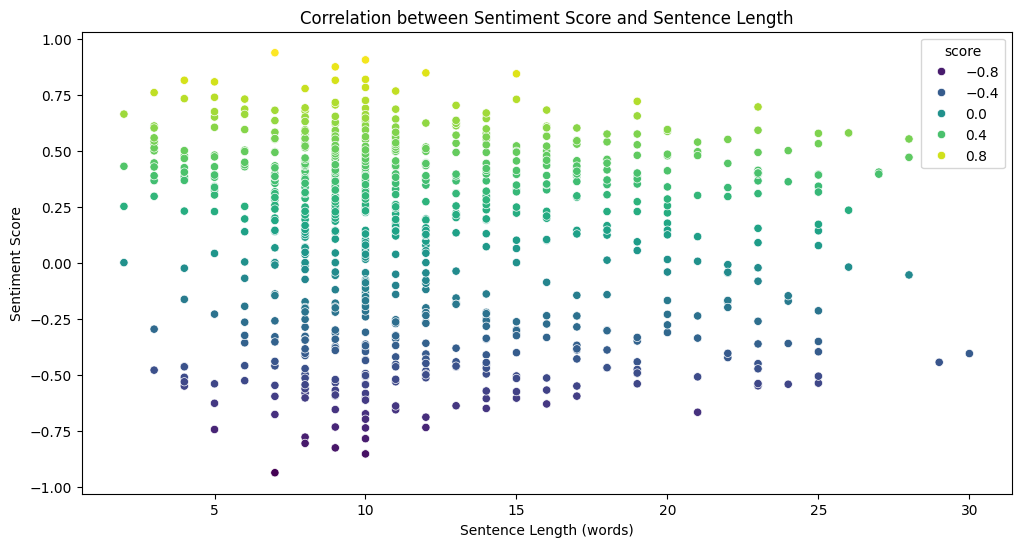

Correlation coefficient between sentence length (chars) and sentiment score: -0.043
Correlation coefficient between sentence length (words) and sentiment score: -0.066


In [11]:
import seaborn as sns

df['char_count'] = df['sentence'].str.len()
df['word_count'] = df['sentence'].apply(lambda x: len(x.split()))

# Plot distributions
plt.figure(figsize=(12, 6))
# Scatter plot to visualize correlation between sentiment score and sentence length
sns.scatterplot(data=df, x='word_count', y='score', hue='score', palette='viridis')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Sentiment Score')
plt.title('Correlation between Sentiment Score and Sentence Length')
plt.show()

# Optionally, show the correlation coefficient
corr1 = df['char_count'].corr(df['score'])
print(f"Correlation coefficient between sentence length (chars) and sentiment score: {corr1:.3f}")
corr2 = df['word_count'].corr(df['score'])
print(f"Correlation coefficient between sentence length (words) and sentiment score: {corr2:.3f}")


There's no strong correlation between sentence length and sentiment.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [ ]:
# Get top 20 bigrams for negative sentiment
negative_text = df[df['score'] < -0.34]['sentence']
top_bigrams = get_top_ngrams(negative_text, n=20, ngram_range=(2, 2))
print("Top 20 Bigrams in Negative Sentences:\n", top_bigrams)

Top 20 Bigrams in Negative Sentences:
 [('http stks', np.int64(25)), ('share price', np.int64(7)), ('sell signal', np.int64(5)), ('looks like', np.int64(4)), ('bhp billiton', np.int64(3)), ('lse deutsche', np.int64(3)), ('standard chartered', np.int64(2)), ('stanchart rbs', np.int64(2)), ('rbs struggle', np.int64(2)), ('struggle bank', np.int64(2)), ('bank england', np.int64(2)), ('england stress', np.int64(2)), ('stress tests', np.int64(2)), ('price tumbles', np.int64(2)), ('shares plunge', np.int64(2)), ('britain ftse', np.int64(2)), ('tesco share', np.int64(2)), ('slashes dividend', np.int64(2)), ('ftse lower', np.int64(2)), ('deutsche boerse', np.int64(2))]


We see some clear negative words like "sell", "struggle", "stress", "tumbles", "plunges", "slashes" and "lower". However, some banks, which should be nuetral, are also present in this mix. Time & Sample Dependency: It looks like there is some ploicy issue within Britian at the moment. Some problems within deutsche bank, rbs and standard chartered banks. There is some links added in the information, they will not provide any relevent information lie "http stks". Some other nuetral words are present in high frequency like "share price". If we want model to be deployed at different time data, Our model should not relate specific banks and regions that may seem to be at precarious situation currently.

In [15]:
# Get top 20 bigrams for postive sentiment
negative_text = df[df['score'] > 0.34]['sentence']
top_bigrams = get_top_ngrams(negative_text, n=20, ngram_range=(2, 2))
print("Top 20 Bigrams in positive Sentences:\n", top_bigrams)

Top 20 Bigrams in positive Sentences:
 [('http stks', np.int64(70)), ('share price', np.int64(12)), ('long setup', np.int64(6)), ('looks like', np.int64(6)), ('britain ftse', np.int64(5)), ('long position', np.int64(5)), ('plc set', np.int64(4)), ('daiichi sankyo', np.int64(4)), ('looking good', np.int64(4)), ('http chart', np.int64(4)), ('chart ly', np.int64(4)), ('cancer drug', np.int64(3)), ('zs pharma', np.int64(3)), ('pharma billion', np.int64(3)), ('ab inbev', np.int64(3)), ('group plc', np.int64(3)), ('itv share', np.int64(3)), ('price jumps', np.int64(3)), ('quarter sales', np.int64(3)), ('balfour beatty', np.int64(3))]


Similar to the negative samples, there is some links added in the information, they will not provide any relevent information lie "http stks". Some other nuetral words are present in high frequency like "share price". This should not be an issue for our model, since these are present in both the samples in similar frequency. Some clear +ve words are also present like "long setup", "long position","looking good" and "price jumps". Similarly, pharma sector seems to be doing well in the samples. And companies are performing well like "ab inbev". Our model should not the relate specific companies or pharma with well.

In older models like TF-IDF with Logistic Regression, this is a massive problem because the model sees words in isolation. The presence of the token "RBS" would add a strong negative weight, regardless of context.
Transformers (like BERT) are inherently more robust to this. Their core mechanism, self-attention, is designed to understand context.The pre-training on a huge corpus gives transformer a strong "prior" that these are just named entities, not inherent sentiment carriers.

**Primary training strategy**: Trust the transformer, but verify.

**Verification strategy** : After training the baseline model, we should look beyond on metrics like F1-score. We need to perform a qualitative error analysis specifically designed to test for the biases we've identified.

**Action**: Create a small, handcrafted test set of "challenge sentences" that are not in your dataset.

**Entity Swap Test**:
"Deutsche Bank announces record profits and a strong outlook." (Should be POSITIVE)
"Pfizer shares plunge after missing earnings estimates." (Should be NEGATIVE)
"Standard Chartered will hold its quarterly earnings call on Tuesday." (Should be NEUTRAL)

**Temporal Test**:
Find a topic that isn't in your data. E.g., "Tesla stock soars after new EV model announcement." (Should be POSITIVE)

                                        **Conclusion & Strategic Recommendations**

Our Exploratory Data Analysis (EDA) of the FiQA sentiment dataset has revealed several critical characteristics that must inform our modeling strategy. The two most important findings are:

**Bimodal Score Distribution**: The sentiment scores are not evenly distributed. They cluster into two distinct peaks—one positive and one negative—with a significant valley in the neutral zone. This makes the choice of classification thresholds critical and suggests that the "neutral" class is both the smallest and the most ambiguous.

**Risk of Spurious Correlations**: The data contains strong but potentially misleading correlations between specific entities (e.g., "Deutsche Bank," "RBS") or sectors ("pharma") and the sentiment at the time the data was collected. A naive model is at high risk of learning these shortcuts (e.g., "if 'RBS' then negative") instead of general rules of sentiment.

Based on these insights, a simple classification approach is fragile. We recommend a more robust, two-stage strategy that decouples the core modeling task from the final business application.

**Primary Recommendation**: A Regression-First Approach

Implementation and Evaluation Strategy

**Model Selection**:
We strongly recommend using a pre-trained, domain-specific transformer model like ProsusAI/finbert or yiyang-zhang/finbert-tone. Its existing knowledge of financial vocabulary and context is invaluable for overcoming the entity-based biases identified in our EDA.

**Training Task**:
Train the model to minimize a regression loss function, such as Mean Squared Error (MSE).

**Evaluation Metrics**:
During Training (Regression): Monitor Mean Squared Error (MSE) or Mean Absolute Error (MAE) on the validation set to track how well the model is learning to predict the scores.

For Final Classification (Inference): After applying your thresholds to the model's output scores, evaluate the final labels using:

Weighted F1-Score: The single most important metric, as it accounts for the severe class imbalance.

Macro F1-Score: Useful for understanding the unweighted average performance across all three classes.

Confusion Matrix: Essential for visualizing exactly where the model is succeeding and failing (e.g., is it misclassifying most neutral sentences as positive?).

Note: Accuracy should be avoided as a primary metric; it will be misleadingly high due to the model's potential to over-predict the majority (positive) class.

**Crucial Post-Training Step**: Active Validation for Bias
A good F1-score is not enough. We must actively probe the model for the spurious correlations we suspect.
Action: Create a small, handcrafted "challenge set" of sentences designed to test the model's generalization. This set should include:

**Entity Swaps**: Positive news about companies that were mostly negative in the training data (e.g., "Deutsche Bank posts record profits").

**Context Reversals**: Negative news about companies that were mostly positive (e.g., "Ab Inbev shares plunge on weak outlook").
Unseen Entities: News about relevant companies or sectors not present in the training data.

**Contingency Plan**: If the model fails this active validation test, it indicates that it has overfit to the training data's biases. The recommended countermeasure is to retrain the model on an augmented dataset using techniques like Entity Masking (replacing all company names with [COMPANY]) to force it to learn from the surrounding context.